<a href="https://colab.research.google.com/github/larrygoyeau/bubble_segmentation_Mask_RCNN/blob/master/train_Mask_RCNN.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Mask R-CNN - Train on bubbles Dataset

In [0]:
%tensorflow_version 1.x

!git clone https://github.com/larrygoyeau/Mask_RCNN
!git clone https://github.com/larrygoyeau/bubble_segmentation_Mask_RCNN
!pip install -r /content/Mask_RCNN/requirements.txt
!pip install git+https://github.com/aleju/imgaug.git

In [0]:
import sys
sys.path.append('/content/Mask_RCNN')

import resource
import os
import random
import math
import re
import time
import numpy as np
import cv2
import matplotlib
import matplotlib.pyplot as plt
from imgaug import augmenters as iaa
import requests

# Root directory of the project
ROOT_DIR = os.path.abspath("/content")

# Import Mask RCNN
from mrcnn.config import Config
from mrcnn import utils
import mrcnn.model as modellib
from mrcnn import visualize
from mrcnn.model import log

%matplotlib inline 

# Directory to save logs and trained model
MODEL_DIR = ROOT_DIR

## Configurations

In [3]:
class ShapesConfig(Config):
    """Configuration for training on the toy shapes dataset.
    Derives from the base Config class and overrides values specific
    to the toy shapes dataset.
    """
    # Give the configuration a recognizable name
    NAME = "shapes"

    DETECTION_MAX_INSTANCES=350
    MAX_GT_INSTANCES=350
    RPN_NMS_THRESHOLD=0.8
    DETECTION_MIN_CONFIDENCE = 0
    RPN_TRAIN_ANCHORS_PER_IMAGE = 64
    # Train on 1 GPU and 1 images per GPU.
    GPU_COUNT = 1
    IMAGES_PER_GPU = 1

    # Number of classes (including background)
    NUM_CLASSES = 1 + 1  # background + 1 shape

    # Use small images for faster training. Set the limits of the small side

    # Random crops of size 512x512
    IMAGE_RESIZE_MODE = "crop"
    IMAGE_MIN_DIM = 512
    IMAGE_MAX_DIM = 512


    # Use smaller anchors because our image and objects are small
    RPN_ANCHOR_SCALES = (8, 16, 32, 64, 128)  # anchor side in pixels

    TRAIN_ROIS_PER_IMAGE = 128

    # Use a small epoch since the images have a lot of bubbles
    STEPS_PER_EPOCH = 100

    # use small validation steps since the epoch is small
    VALIDATION_STEPS = 5
    
config = ShapesConfig()
config.display()


Configurations:
BACKBONE                       resnet101
BACKBONE_STRIDES               [4, 8, 16, 32, 64]
BATCH_SIZE                     1
BBOX_STD_DEV                   [0.1 0.1 0.2 0.2]
COMPUTE_BACKBONE_SHAPE         None
DETECTION_MAX_INSTANCES        350
DETECTION_MIN_CONFIDENCE       0
DETECTION_NMS_THRESHOLD        0.3
FPN_CLASSIF_FC_LAYERS_SIZE     1024
GPU_COUNT                      1
GRADIENT_CLIP_NORM             5.0
IMAGES_PER_GPU                 1
IMAGE_CHANNEL_COUNT            3
IMAGE_MAX_DIM                  512
IMAGE_META_SIZE                14
IMAGE_MIN_DIM                  512
IMAGE_MIN_SCALE                0
IMAGE_RESIZE_MODE              crop
IMAGE_SHAPE                    [512 512   3]
LEARNING_MOMENTUM              0.9
LEARNING_RATE                  0.001
LOSS_WEIGHTS                   {'rpn_class_loss': 1.0, 'rpn_bbox_loss': 1.0, 'mrcnn_class_loss': 1.0, 'mrcnn_bbox_loss': 1.0, 'mrcnn_mask_loss': 1.0}
MASK_POOL_SIZE                 14
MASK_SHAPE                 

## Notebook Preferences

In [0]:
def get_ax(rows=1, cols=1, size=8):
    """Return a Matplotlib Axes array to be used in
    all visualizations in the notebook. Provide a
    central point to control graph sizes.
    
    Change the default size attribute to control the size
    of rendered images
    """
    _, ax = plt.subplots(rows, cols, figsize=(size*cols, size*rows))
    return ax

## Dataset

Create a synthetic dataset

Extend the Dataset class and add a method to load the shapes dataset, `load_shapes()`, and override the following methods:

* load_image()
* load_mask()
* image_reference()

In [0]:
# To increas the recursion limite
resource.setrlimit(resource.RLIMIT_STACK, [0x100000000, resource.RLIM_INFINITY])
sys.setrecursionlimit(0x1000000)

DATA_DIR = '/content/bubble_segmentation_Mask_RCNN/data_set'

x_train_dir = os.path.join(DATA_DIR, 'image_train')
interior_y_train_dir = os.path.join(DATA_DIR, 'interior_mask_train')
contour_y_train_dir = os.path.join(DATA_DIR, 'contour_mask_train')

x_valid_dir = os.path.join(DATA_DIR, 'image_validation')
interior_y_valid_dir = os.path.join(DATA_DIR, 'interior_mask_validation')
contour_y_valid_dir = os.path.join(DATA_DIR, 'contour_mask_validation')

x_test_dir = os.path.join(DATA_DIR, 'image_test')

def color_bubble(mask_of_one_bubble,mask,i,j,I,J,color_of_bubble_done,color_of_bubbles_to_be_done):
  if mask[i,j]<color_of_bubbles_to_be_done:
    mask[i,j]=color_of_bubble_done
    mask_of_one_bubble[i,j]=1
    if 0<j:
      color_bubble(mask_of_one_bubble,mask,i,j-1,I,J,color_of_bubble_done,color_of_bubbles_to_be_done)
    if i<I-1:
      color_bubble(mask_of_one_bubble,mask,i+1,j,I,J,color_of_bubble_done,color_of_bubbles_to_be_done)
    if 0<i:
      color_bubble(mask_of_one_bubble,mask,i-1,j,I,J,color_of_bubble_done,color_of_bubbles_to_be_done)
    if j<J-1:
      color_bubble(mask_of_one_bubble,mask,i,j+1,I,J,color_of_bubble_done,color_of_bubbles_to_be_done)

class ShapesDataset(utils.Dataset):


    def load_shapes(self,images_dir, masks_dir):

        # Add classes
        self.add_class("shapes", 1, "bubble")

        # Add images
        self.ids_image = os.listdir(images_dir)
        
        self.images_fps = [os.path.join(images_dir, image_id) for image_id in self.ids_image]
        if masks_dir!=None:
          self.masks_fps = [os.path.join(masks_dir,'mask'+image_id[5:]) for image_id in self.ids_image]
        else:
          self.masks_fps=None

        count=len(self.ids_image)
        
        for i in range(count):
            self.add_image("shapes", image_id=i, path=self.images_fps[i],path_mask=self.masks_fps[i])

    def load_image(self, image_id):
        """Generate an image from the specs of the given image ID.
        This function loads the image from a file
        """
        info = self.image_info[image_id]
        image = cv2.imread(info['path'])
        if len(image)>2**11:
          image=image[:2**11,:]
        if len(image[0])>2**11:
          image=image[:,:2**11]
        shape_image=image.shape
        p=255/(image.max()-image.min())
        image=(image-image.min())*p
        image= image.astype(np.uint8)
        image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
        return image

    def load_mask(self, image_id):
        """The annotations are the same as those used for Unet 
        except that this function allows you to create, 
        from a mask containing all the bubbles,
         a set of mask, each containing a bubble so that the annotation is indeed of the type 
         'instance' and not 'semantic'.
        """
        info = self.image_info[image_id]
        mask = cv2.imread(info['path_mask'], 0)
        I=len(mask)
        J=len(mask[0])
        number_of_bubbles=0
        list_of_mask=[]
        for i in range(I):
          for j in range(J):
            if mask[i,j]<5:
              mask_of_one_bubble=np.zeros( mask.shape, dtype=np.int32 )
              color_bubble(mask_of_one_bubble,mask,i,j,I,J,255,5)
              list_of_mask=list_of_mask+[mask_of_one_bubble]
              number_of_bubbles=number_of_bubbles+1
        list_of_mask=np.random.permutation(list_of_mask)
        mask_of_all_bubbles = np.stack(list_of_mask, axis=-1).astype('int')
        class_ids = np.ones((number_of_bubbles))
        return mask_of_all_bubbles.astype(np.bool), class_ids.astype(np.int32)


In [0]:
# Training dataset
dataset_train = ShapesDataset()
dataset_train.load_shapes(x_train_dir, interior_y_train_dir)
dataset_train.prepare()

# Validation dataset
dataset_val = ShapesDataset()
dataset_val.load_shapes(x_valid_dir, interior_y_valid_dir)
dataset_val.prepare()

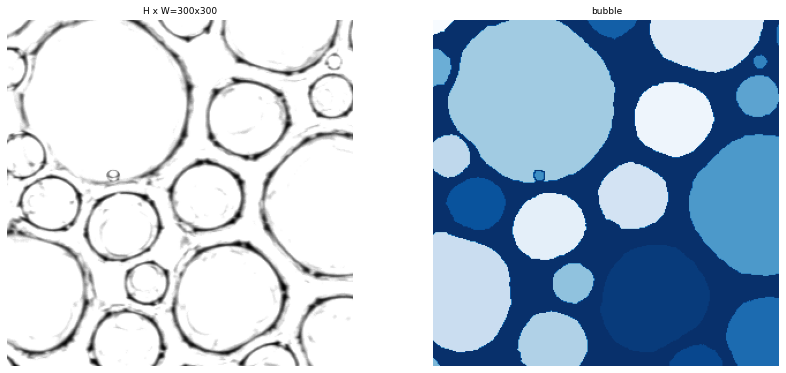

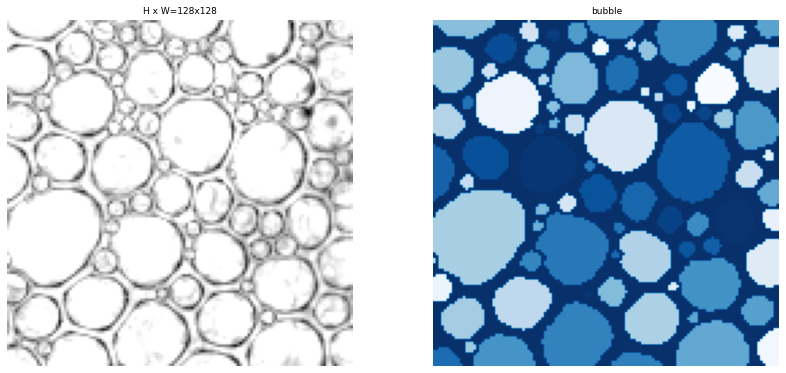

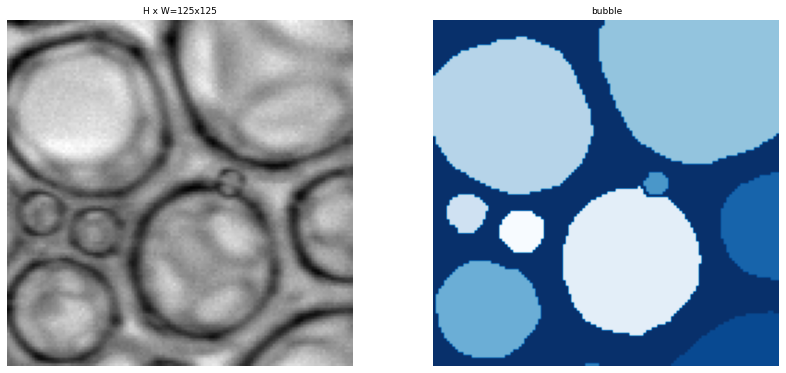

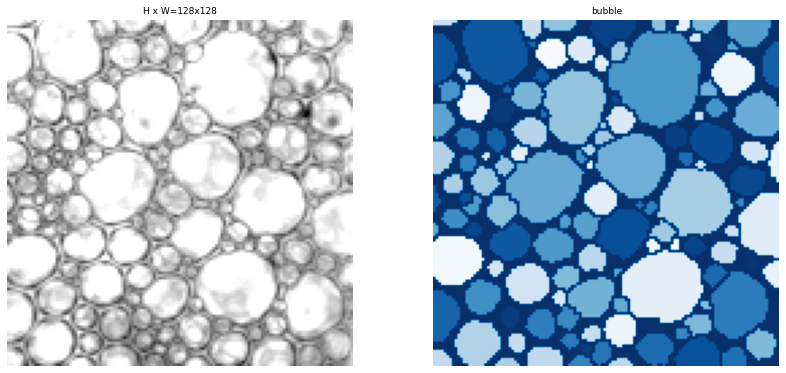

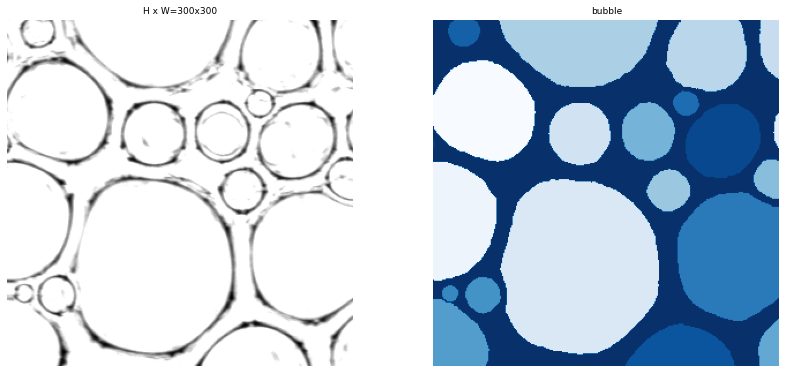

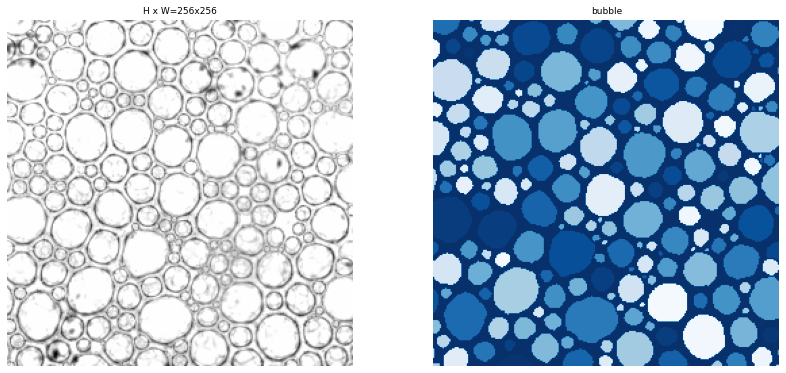

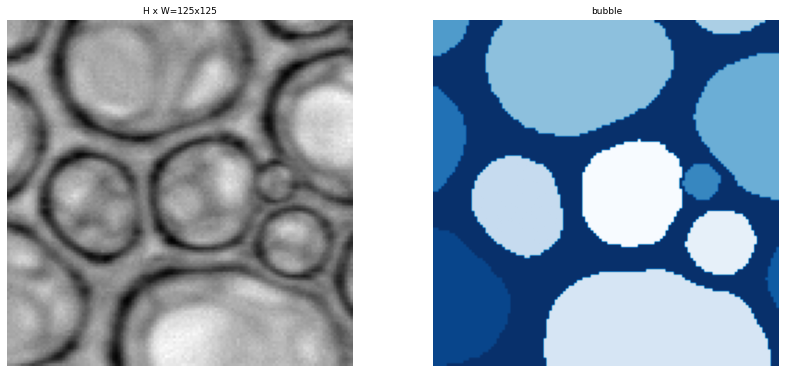

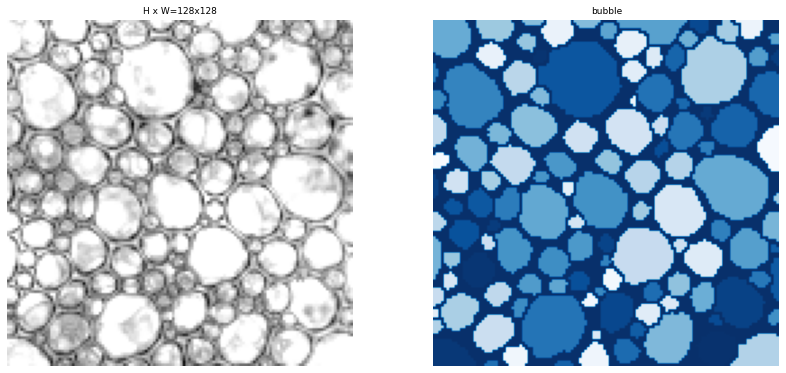

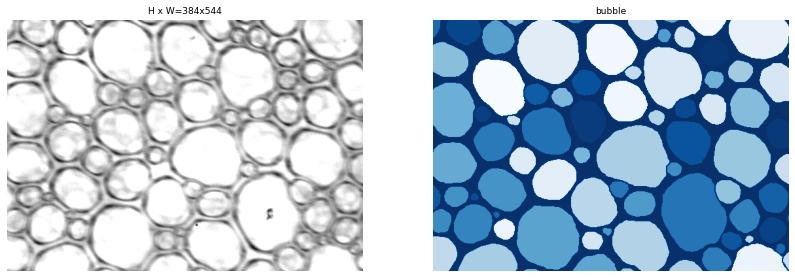

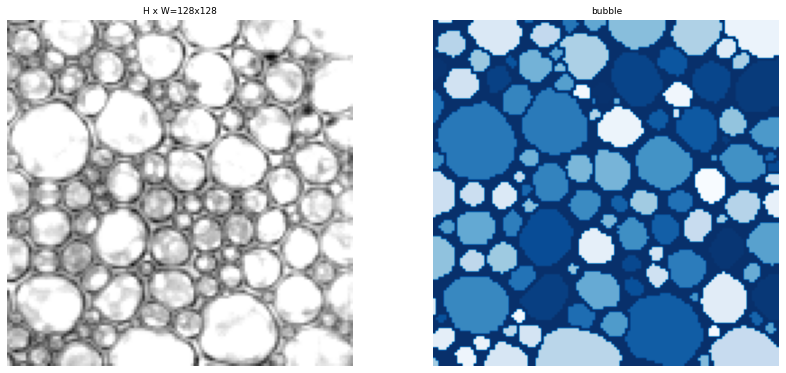

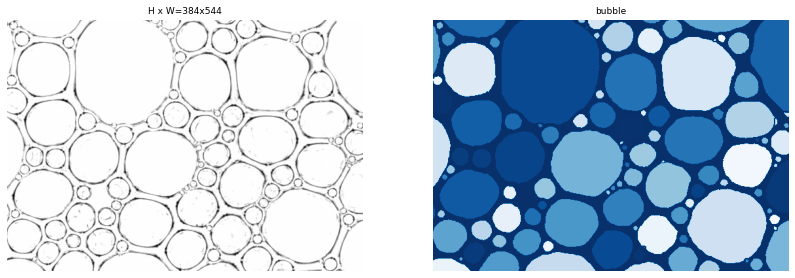

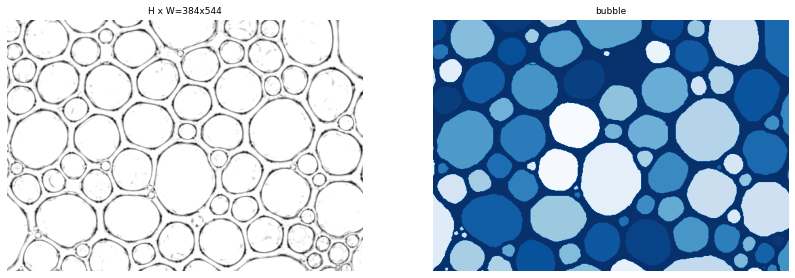

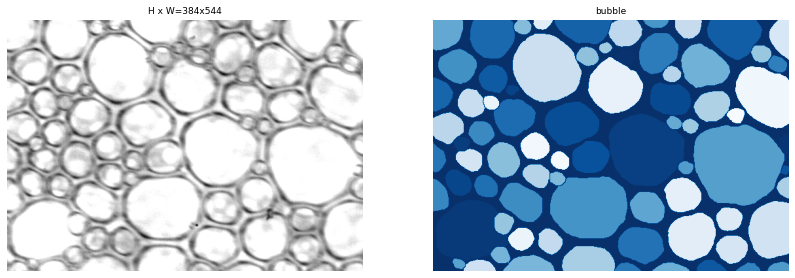

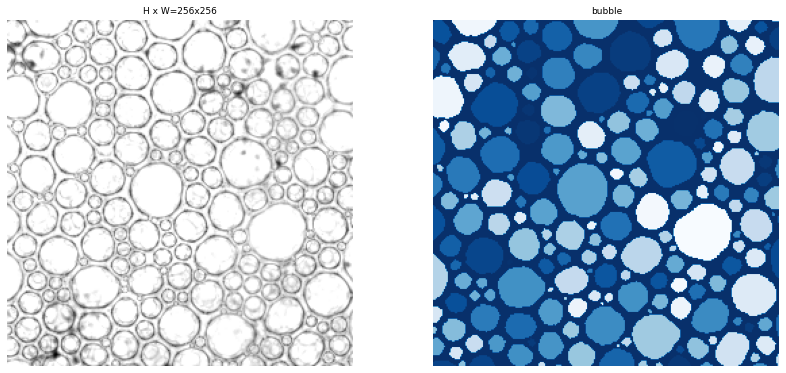

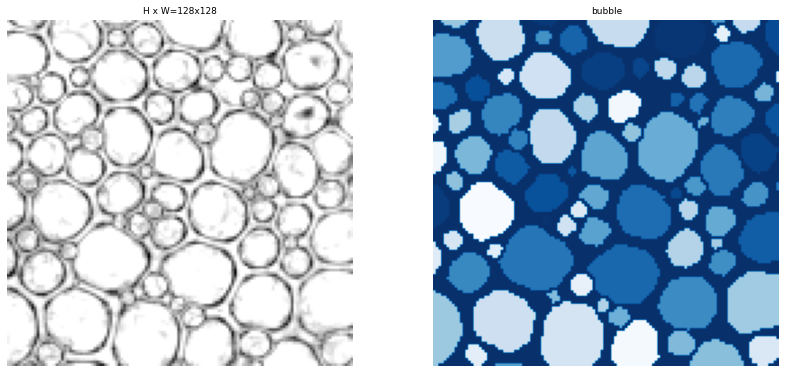

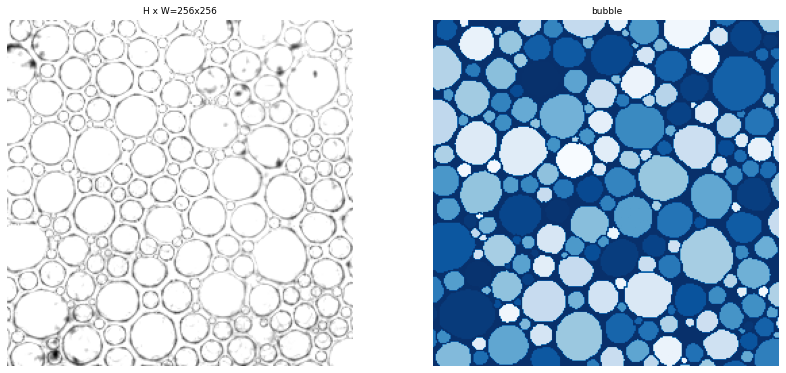

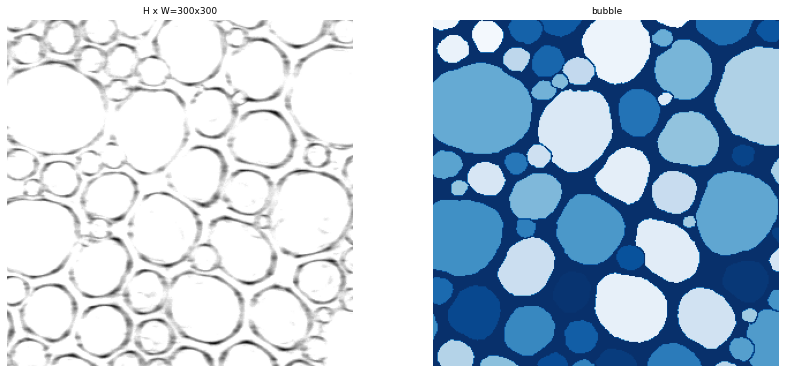

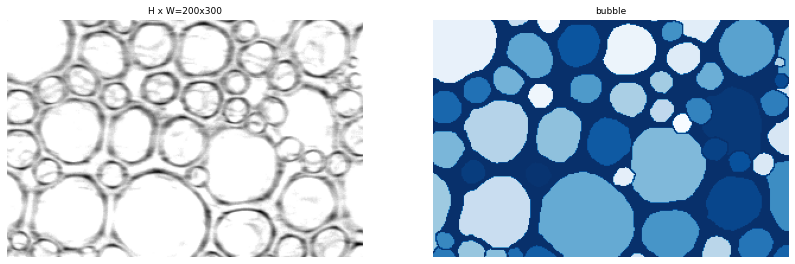

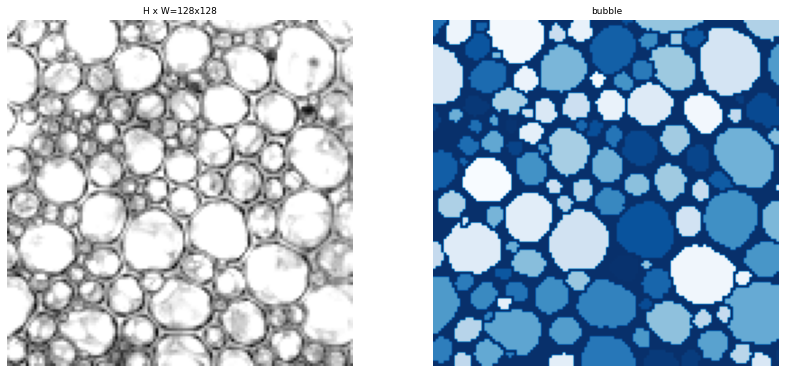

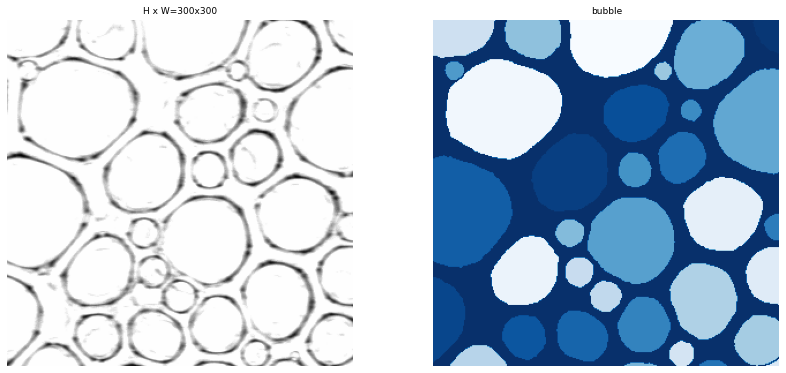

In [7]:
# Load and display samples

n =len(os.listdir(x_train_dir))
for image_id in range(n):
    image = dataset_train.load_image(image_id)
    mask, class_ids = dataset_train.load_mask(image_id)
    visualize.display_top_masks(image, mask, class_ids, dataset_train.class_names,limit=1)


# Data augmentation

In [0]:
augment = iaa.SomeOf((1,3), [
        iaa.Fliplr(1),
        iaa.Flipud(1),
        iaa.Affine(rotate=(-90, 90)),
        iaa.Multiply((0.8, 1),per_channel=0.5),
        #iaa.WithChannels(0, iaa.Add((10, 60))),
        #iaa.Add((-25, 25), per_channel=0.5),
        #iaa.AddToHueAndSaturation((-50, 50), per_channel=True),
        #iaa.ChangeColorTemperature((4000, 5000)),
        #iaa.GammaContrast((0.5, 2.0), per_channel=True),
        #iaa.AllChannelsHistogramEqualization(),
        #iaa.PiecewiseAffine(scale=(0.04, 0.06)),
        iaa.PiecewiseAffine(scale=(0.04, 0.06))

    ])

/usr/local/lib/python3.6/dist-packages/imgaug/augmenters/base.py:59: SuspiciousSingleImageShapeWarning: You provided a numpy array of shape (512, 512, 56) as a single-image augmentation input, which was interpreted as (H, W, C). The last dimension however has a size of >=32, which indicates that you provided a multi-image array with shape (N, H, W) instead. If that is the case, you should use e.g. augmenter(imageS=<your input>) or augment_imageS(<your input>). Otherwise your multi-image input will be interpreted as a single image during augmentation.
  category=SuspiciousSingleImageShapeWarning)


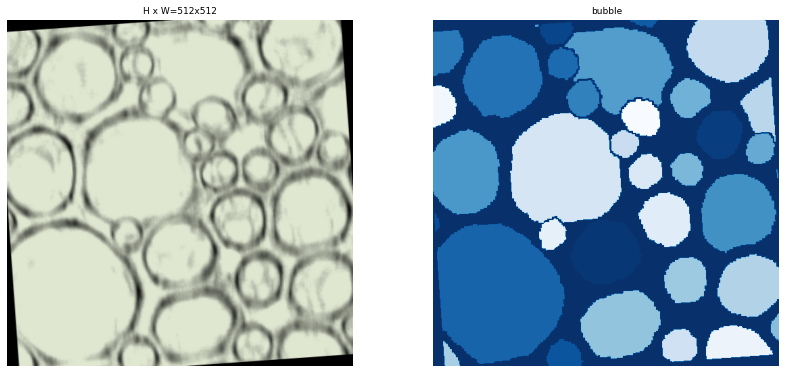

/usr/local/lib/python3.6/dist-packages/imgaug/augmenters/base.py:59: SuspiciousSingleImageShapeWarning: You provided a numpy array of shape (512, 512, 206) as a single-image augmentation input, which was interpreted as (H, W, C). The last dimension however has a size of >=32, which indicates that you provided a multi-image array with shape (N, H, W) instead. If that is the case, you should use e.g. augmenter(imageS=<your input>) or augment_imageS(<your input>). Otherwise your multi-image input will be interpreted as a single image during augmentation.
  category=SuspiciousSingleImageShapeWarning)


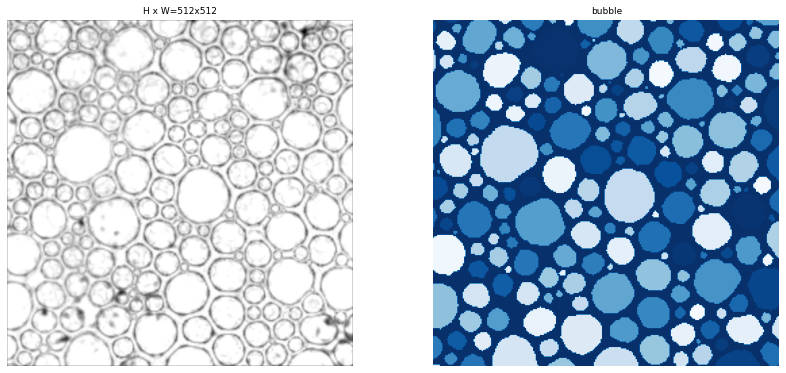

/usr/local/lib/python3.6/dist-packages/imgaug/augmenters/base.py:59: SuspiciousSingleImageShapeWarning: You provided a numpy array of shape (512, 512, 32) as a single-image augmentation input, which was interpreted as (H, W, C). The last dimension however has a size of >=32, which indicates that you provided a multi-image array with shape (N, H, W) instead. If that is the case, you should use e.g. augmenter(imageS=<your input>) or augment_imageS(<your input>). Otherwise your multi-image input will be interpreted as a single image during augmentation.
  category=SuspiciousSingleImageShapeWarning)


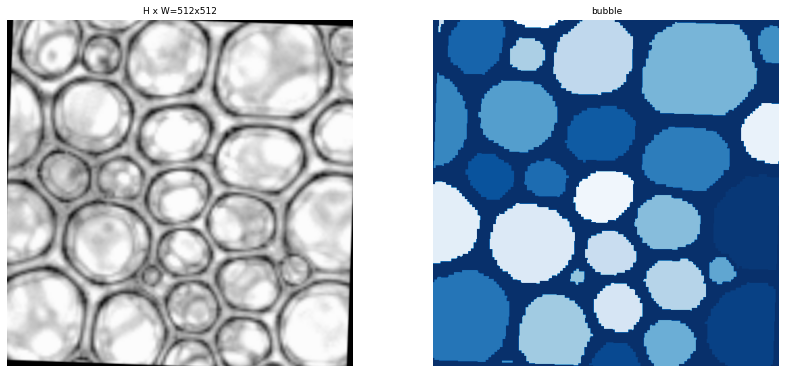

/usr/local/lib/python3.6/dist-packages/imgaug/augmenters/base.py:59: SuspiciousSingleImageShapeWarning: You provided a numpy array of shape (512, 512, 80) as a single-image augmentation input, which was interpreted as (H, W, C). The last dimension however has a size of >=32, which indicates that you provided a multi-image array with shape (N, H, W) instead. If that is the case, you should use e.g. augmenter(imageS=<your input>) or augment_imageS(<your input>). Otherwise your multi-image input will be interpreted as a single image during augmentation.
  category=SuspiciousSingleImageShapeWarning)


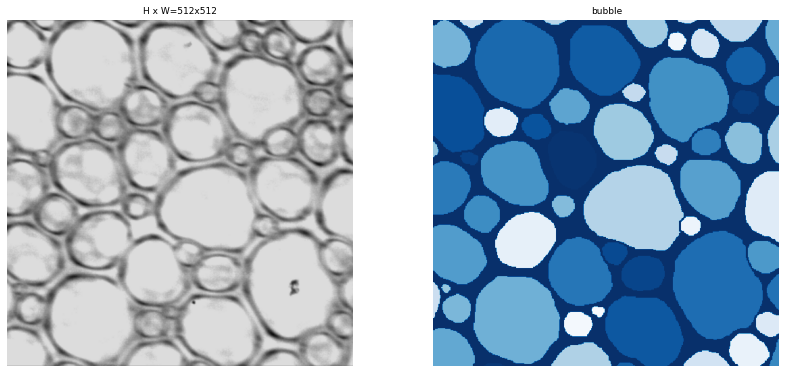

/usr/local/lib/python3.6/dist-packages/imgaug/augmenters/base.py:59: SuspiciousSingleImageShapeWarning: You provided a numpy array of shape (512, 512, 110) as a single-image augmentation input, which was interpreted as (H, W, C). The last dimension however has a size of >=32, which indicates that you provided a multi-image array with shape (N, H, W) instead. If that is the case, you should use e.g. augmenter(imageS=<your input>) or augment_imageS(<your input>). Otherwise your multi-image input will be interpreted as a single image during augmentation.
  category=SuspiciousSingleImageShapeWarning)


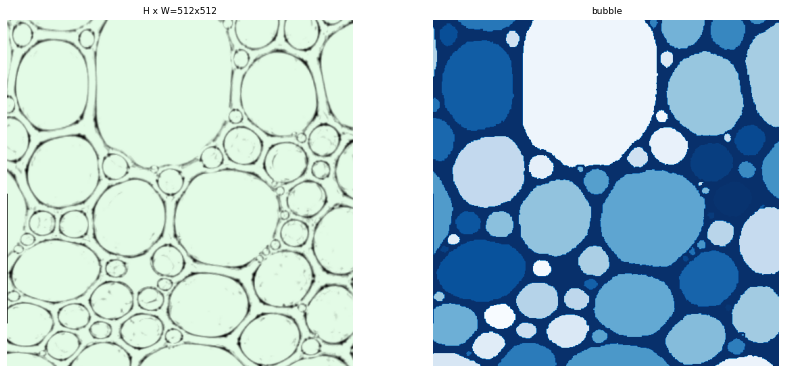

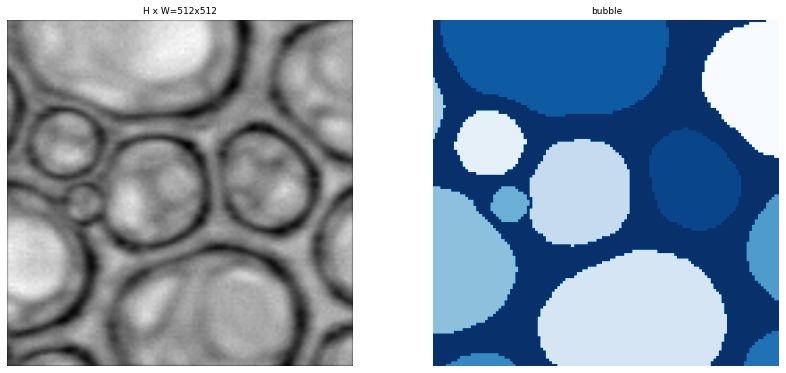

/usr/local/lib/python3.6/dist-packages/imgaug/augmenters/base.py:59: SuspiciousSingleImageShapeWarning: You provided a numpy array of shape (512, 512, 115) as a single-image augmentation input, which was interpreted as (H, W, C). The last dimension however has a size of >=32, which indicates that you provided a multi-image array with shape (N, H, W) instead. If that is the case, you should use e.g. augmenter(imageS=<your input>) or augment_imageS(<your input>). Otherwise your multi-image input will be interpreted as a single image during augmentation.
  category=SuspiciousSingleImageShapeWarning)


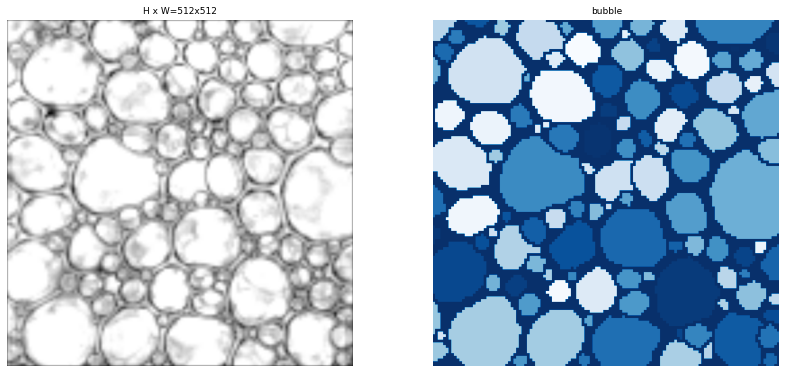

In [0]:
# Load and display samples

n =len(os.listdir(x_valid_dir))
for image_id in range(n):
    image, image_meta, class_ids, bbox, mask = modellib.load_image_gt(dataset_val, config, image_id, augmentation=augment)
    visualize.display_top_masks(image, mask, class_ids, dataset_val.class_names,limit=1)
    

## Create Model

In [8]:

# Download trained weights from Releases if needed

def download_file_from_google_drive(id, destination):
    URL = "https://docs.google.com/uc?export=download"

    session = requests.Session()

    response = session.get(URL, params = { 'id' : id }, stream = True)
    token = get_confirm_token(response)

    if token:
        params = { 'id' : id, 'confirm' : token }
        response = session.get(URL, params = params, stream = True)

    save_response_content(response, destination)    

def get_confirm_token(response):
    for key, value in response.cookies.items():
        if key.startswith('download_warning'):
            return value

    return None

def save_response_content(response, destination):
    CHUNK_SIZE = 32768

    with open(destination, "wb") as f:
        for chunk in response.iter_content(CHUNK_SIZE):
            if chunk: # filter out keep-alive new chunks
                f.write(chunk)

MODEL_PATH = '/content/model.h5'

if not os.path.exists(MODEL_PATH):
    file_id = '16m6o97REebp_C86IbjbaHitxUvjBjrBe'
    destination = MODEL_PATH
    download_file_from_google_drive(file_id, destination)
    print("Pretrained model downloaded!")

Pretrained model downloaded!


In [9]:
# Create model in training mode
model = modellib.MaskRCNN(mode="training", config=config,
                          model_dir=MODEL_DIR)

# Load the pretrained weights
model.load_weights(MODEL_PATH, by_name=True)

Instructions for updating:
If using Keras pass *_constraint arguments to layers.

Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where


Instructions for updating:
box_ind is deprecated, use box_indices instead


## Training

Train in two stages:
1. Only the heads. Here we're freezing all the backbone layers and training only the randomly initialized layers (i.e. the ones that we didn't use pre-trained weights from MS COCO). To train only the head layers, pass `layers='heads'` to the `train()` function.

2. Fine-tune all layers. For this simple example it's not necessary, but we're including it to show the process. Simply pass `layers="all` to train all layers.

In [0]:
epochs_number=3
# Train the head branches
# Passing layers="heads" freezes all layers except the head
# layers. You can also pass a regular expression to select
# which layers to train by name pattern.
model.train(dataset_train, dataset_val, 
            learning_rate=config.LEARNING_RATE/10, 
            epochs=epochs_number, 
            layers='heads',
            augmentation=augment
            )

In [0]:
# Fine tune all layers
# Passing layers="all" trains all layers. You can also 
# pass a regular expression to select which layers to
# train by name pattern.
model.train(dataset_train, dataset_val, 
            learning_rate=config.LEARNING_RATE/100,
            epochs=epochs_number+2, 
            layers="all",
            augmentation=augment
            )

## Evaluation

In [0]:
class InferenceConfig(ShapesConfig):
    GPU_COUNT = 1
    IMAGES_PER_GPU = 1
    IMAGE_RESIZE_MODE = "pad64"
    RPN_NMS_THRESHOLD = 0.55
    DETECTION_MAX_INSTANCES=350
    MAX_GT_INSTANCES=350
    DETECTION_MIN_CONFIDENCE=0


inference_config = InferenceConfig()

# Recreate the model in inference mode
model = modellib.MaskRCNN(mode="inference", 
                          config=inference_config,
                          model_dir=MODEL_DIR)

# Get path to saved weights
# Either set a specific path or find last trained weights
model_path = model.find_last()

# Load trained weights
print("Loading weights from ", model_path)
model.load_weights(model_path, by_name=True)

inference_config.display()

Processing 1 images
image                    shape: (384, 544, 3)         min:   69.00000  max:  255.00000  uint8
molded_images            shape: (1, 512, 768, 3)      min: -123.70000  max:  151.10000  float64
image_metas              shape: (1, 14)               min:    0.00000  max:  768.00000  float64
anchors                  shape: (1, 98208, 4)         min:   -0.17712  max:    1.05188  float32

70
Processing 1 images
image                    shape: (384, 544, 3)         min:  104.00000  max:  255.00000  uint8
molded_images            shape: (1, 512, 768, 3)      min: -123.70000  max:  151.10000  float64
image_metas              shape: (1, 14)               min:    0.00000  max:  768.00000  float64
anchors                  shape: (1, 98208, 4)         min:   -0.17712  max:    1.05188  float32
95
Processing 1 images
image                    shape: (128, 128, 3)         min:  117.00000  max:  255.00000  uint8
molded_images            shape: (1, 512, 512, 3)      min:   -6.70000  max:

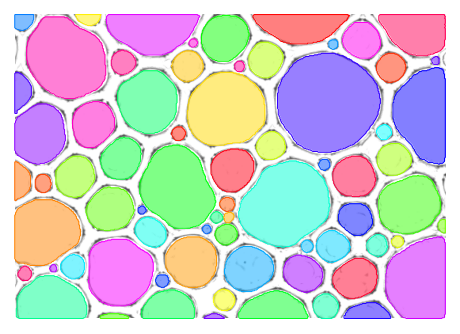

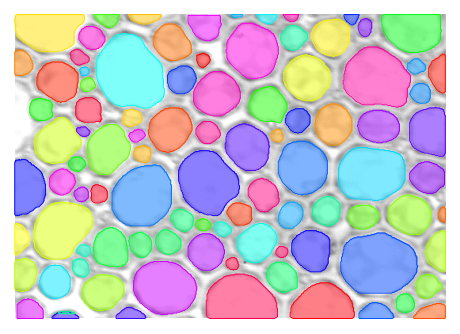

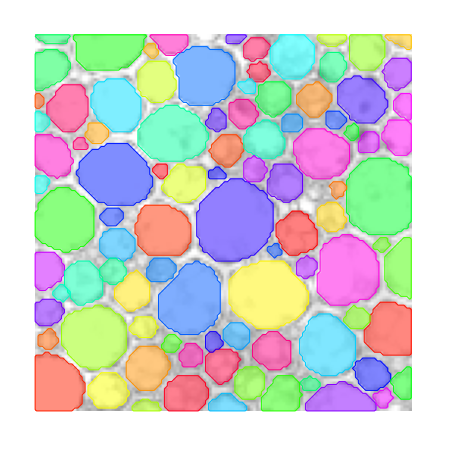

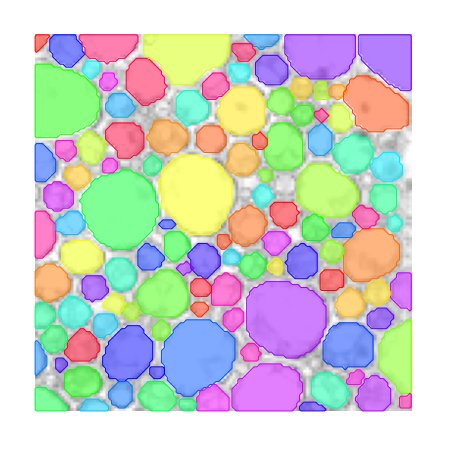

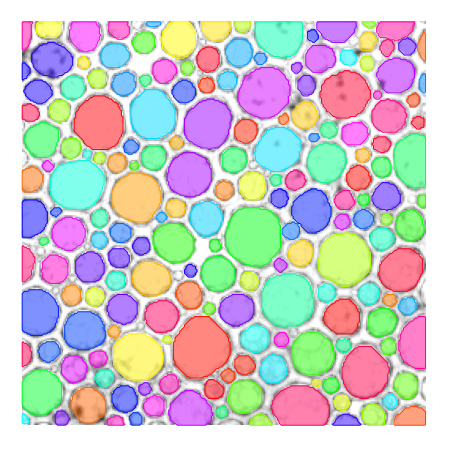

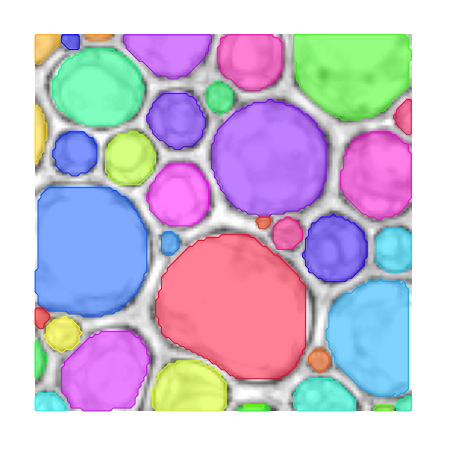

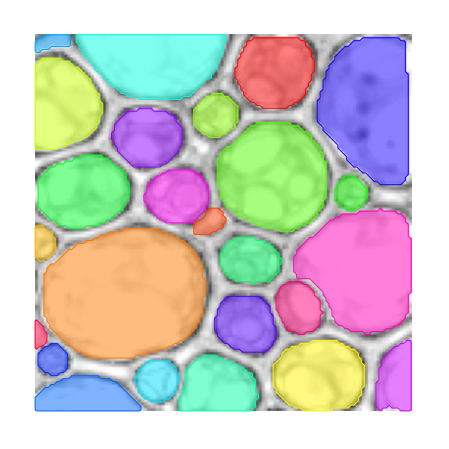

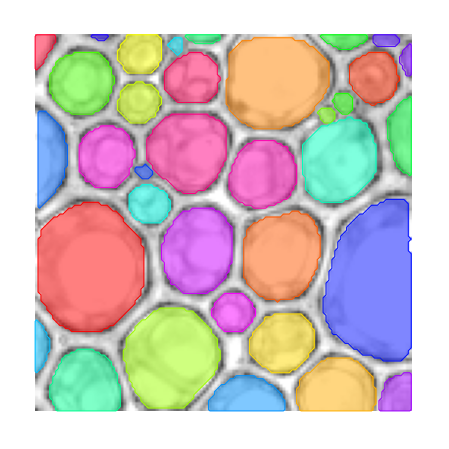

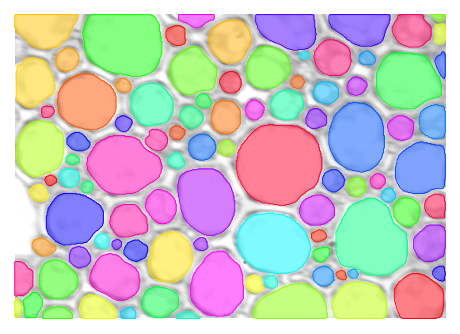

In [0]:
# Load test images
file_names = next(os.walk(x_test_dir))[2]

for image_name in file_names:
  path=os.path.join(x_test_dir, image_name)
  image = cv2.imread(path)
  # Run detection
  results = model.detect([image], verbose=1)
  r = results[0]
  visualize.display_instances(image, r['rois'], r['masks'], r['class_ids'], 
                            ['BG', ' '], np.zeros((len(r['class_ids']))) ,ax=get_ax(),show_bbox=False)
  print(len(r['class_ids']))

In [10]:
model.keras_model.summary()

Model: "mask_rcnn"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_image (InputLayer)        (None, None, None, 3 0                                            
__________________________________________________________________________________________________
zero_padding2d_1 (ZeroPadding2D (None, None, None, 3 0           input_image[0][0]                
__________________________________________________________________________________________________
conv1 (Conv2D)                  (None, None, None, 6 9472        zero_padding2d_1[0][0]           
__________________________________________________________________________________________________
bn_conv1 (BatchNorm)            (None, None, None, 6 256         conv1[0][0]                      
__________________________________________________________________________________________